# Multi-GPU Multi-Node

These examples all cover dyanamical simulation of spin qubits using multiple GPUs. These examples use small systems, but note that the GPU will only provide an advantage for systems with total dimension of O(1000).

## Initial State

This example demonstrates simulation of an initial state on multiple GPUs.

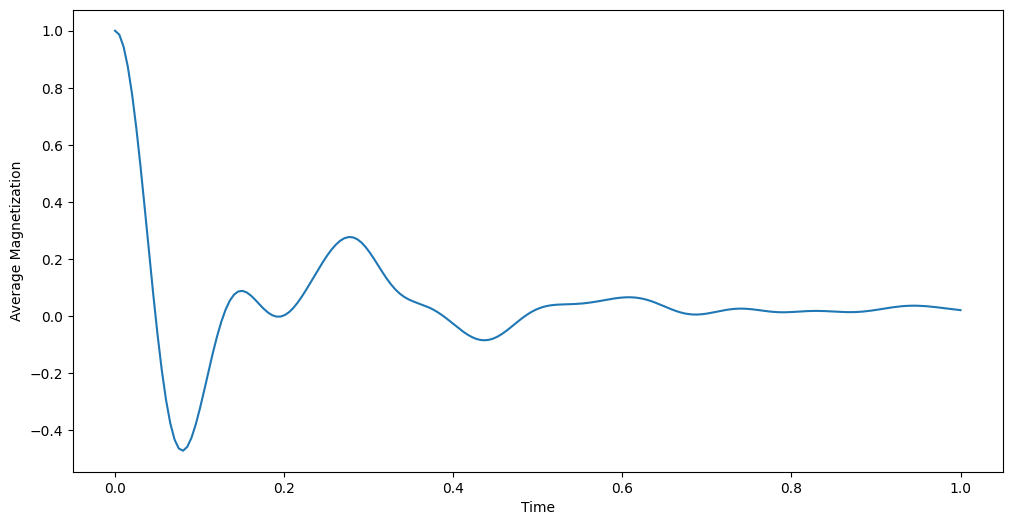

In [2]:
import cudaq
from cudaq import spin, Schedule, RungeKuttaIntegrator

import numpy as np
import matplotlib.pyplot as plt
import os

# On a system with multiple GPUs, `mpiexec` can be used as follows:
# `mpiexec -np <N> python3 multi_gpu.py `
cudaq.mpi.initialize()

# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# Large number of spins
N = 20
dimensions = {}
for i in range(N):
    dimensions[i] = 2

# Observable is the average magnetization operator
avg_magnetization_op = spin.empty()
for i in range(N):
    avg_magnetization_op += (spin.z(i) / N)

# Arbitrary coupling constant
g = 1.0
# Construct the Hamiltonian
H = spin.empty()
for i in range(N):
    H += 2 * np.pi * spin.x(i)
    H += 2 * np.pi * spin.y(i)
for i in range(N - 1):
    H += 2 * np.pi * g * spin.x(i) * spin.x(i + 1)
    H += 2 * np.pi * g * spin.y(i) * spin.z(i + 1)

steps = np.linspace(0.0, 1, 200)
schedule = Schedule(steps, ["time"])

# Initial state (expressed as an enum)
psi0 = cudaq.dynamics.InitialState.ZERO
# This can also be used to initialize a uniformly-distributed wave-function instead.
# `psi0 = cudaq.dynamics.InitialState.UNIFORM`

# Run the simulation
evolution_result = cudaq.evolve(H,
                                dimensions,
                                schedule,
                                psi0,
                                observables=[avg_magnetization_op],
                                collapse_operators=[],
                                store_intermediate_results=True,
                                integrator=RungeKuttaIntegrator())

exp_val = [
    exp_vals[0].expectation()
    for exp_vals in evolution_result.expectation_values()
]

if cudaq.mpi.rank() == 0:
    # Plot the results
    fig = plt.figure(figsize=(12, 6))
    plt.plot(steps, exp_val)
    plt.ylabel("Average Magnetization")
    plt.xlabel("Time")

cudaq.mpi.finalize()

## Heisenberg Model

Simulation of the Heisenberg model using multiple GPUs.

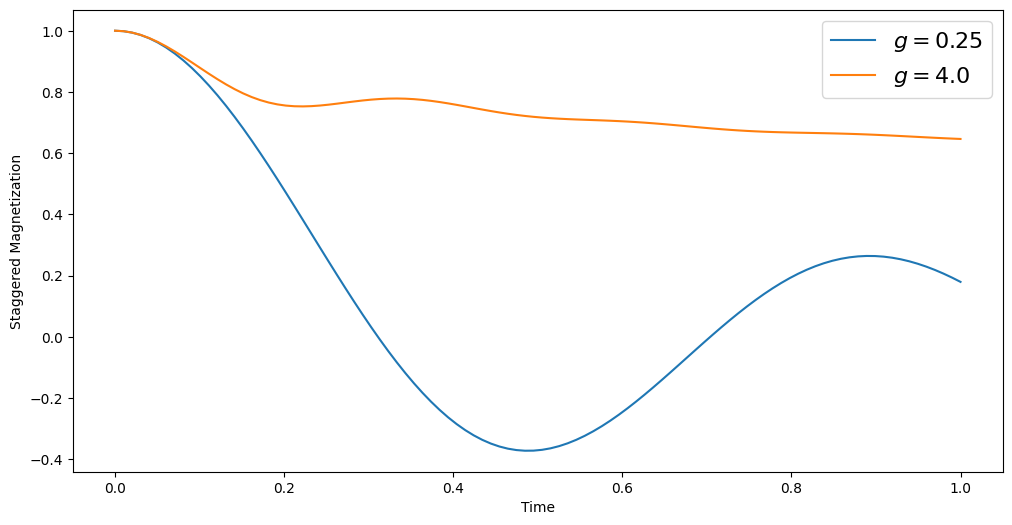

In [1]:
import cudaq
from cudaq import spin, Schedule, RungeKuttaIntegrator

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import os

# On a system with multiple GPUs, `mpiexec` can be used as follows:
# `mpiexec -np <N> python3 multi_gpu.py `
cudaq.mpi.initialize()

# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# Large number of spins
N = 21
dimensions = {}
for i in range(N):
    dimensions[i] = 2

# Initial state: alternating spin up and down
spin_state = ''
for i in range(N):
    spin_state += str(int(i % 2))

# Observable is the staggered magnetization operator
staggered_magnetization_op = spin.empty()
for i in range(N):
    if i % 2 == 0:
        staggered_magnetization_op += spin.z(i)
    else:
        staggered_magnetization_op -= spin.z(i)

staggered_magnetization_op /= N

observe_results = []
for g in [0.25, 4.0]:
    # Heisenberg model spin coupling strength
    Jx = 1.0
    Jy = 1.0
    Jz = g

    # Construct the Hamiltonian
    H = spin.empty()

    for i in range(N - 1):
        H += Jx * spin.x(i) * spin.x(i + 1)
        H += Jy * spin.y(i) * spin.y(i + 1)
        H += Jz * spin.z(i) * spin.z(i + 1)

    steps = np.linspace(0.0, 1, 100)
    schedule = Schedule(steps, ["time"])

    # Prepare the initial state vector
    psi0_ = cp.zeros(2**N, dtype=cp.complex128)
    psi0_[int(spin_state, 2)] = 1.0
    psi0 = cudaq.State.from_data(psi0_)

    # Run the simulation
    evolution_result = cudaq.evolve(H,
                                    dimensions,
                                    schedule,
                                    psi0,
                                    observables=[staggered_magnetization_op],
                                    collapse_operators=[],
                                    store_intermediate_results=True,
                                    integrator=RungeKuttaIntegrator())

    exp_val = [
        exp_vals[0].expectation()
        for exp_vals in evolution_result.expectation_values()
    ]

    observe_results.append((g, exp_val))

if cudaq.mpi.rank() == 0:
    # Plot the results
    fig = plt.figure(figsize=(12, 6))
    for g, exp_val in observe_results:
        plt.plot(steps, exp_val, label=f'$ g = {g}$')
    plt.legend(fontsize=16)
    plt.ylabel("Staggered Magnetization")
    plt.xlabel("Time")

cudaq.mpi.finalize()